# 케라스 Word2Vec 구현

* 참고: https://wikidocs.net/69141

### 전처리

In [ ]:
from sklearn.datasets import fetch_20newsgroups

dataset = fetch_20newsgroups(shuffle=True, random_state=1,
                             remove={'headers', 'footers', 'quotes'})
documents = dataset.data

print(len(documents))
documents[1]

11314


"\n\n\n\n\n\n\nYeah, do you expect people to read the FAQ, etc. and actually accept hard\natheism?  No, you need a little leap of faith, Jimmy.  Your logic runs out\nof steam!\n\n\n\n\n\n\n\nJim,\n\nSorry I can't pity you, Jim.  And I'm sorry that you have these feelings of\ndenial about the faith you need to get by.  Oh well, just pretend that it will\nall end happily ever after anyway.  Maybe if you start a new newsgroup,\nalt.atheist.hard, you won't be bummin' so much?\n\n\n\n\n\n\nBye-Bye, Big Jim.  Don't forget your Flintstone's Chewables!  :) \n--\nBake Timmons, III"

In [ ]:
import re
import nltk

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('stopwords')
nltk.download('punkt')

def clean_text(d):
  pattern = r'[^a-zA-Z\s]'
  text = re.sub(pattern, '', d)
  return text

def clean_stopword(d):
  stop_words = stopwords.words('english')
  return ' '.join([w.lower() for w in d.split() if w.lower() not in stop_words and len(w) > 3])

def tokenize(d):
  return word_tokenize(d)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
import pandas as pd

news_df = pd.DataFrame({'article':documents})
len(news_df)

11314

In [ ]:
news_df.replace("", float("NaN"), inplace=True)
news_df.dropna(inplace=True)
len(news_df)

11096

In [ ]:
news_df['article'] = news_df['article'].apply(clean_text)
news_df['article']

0        Well im not sure about the story nad it did se...
1        \n\n\n\n\n\n\nYeah do you expect people to rea...
2        Although I realize that principle is not one o...
3        Notwithstanding all the legitimate fuss about ...
4        Well I will have to change the scoring on my p...
                               ...                        
11309    Danny Rubenstein an Israeli journalist will be...
11310                                                   \n
11311    \nI agree  Home runs off Clemens are always me...
11312    I used HP DeskJet with Orange Micros Grappler ...
11313                                          \nNo arg...
Name: article, Length: 11096, dtype: object

In [ ]:
news_df['article'] = news_df['article'].apply(clean_stopword)
news_df['article']

0        well sure story seem biased disagree statement...
1        yeah expect people read actually accept hard a...
2        although realize principle strongest points wo...
3        notwithstanding legitimate fuss proposal much ...
4        well change scoring playoff pool unfortunately...
                               ...                        
11309    danny rubenstein israeli journalist speaking t...
11310                                                     
11311    agree home runs clemens always memorable kinda...
11312    used deskjet orange micros grappler system upd...
11313    argument murphy scared hell came last year han...
Name: article, Length: 11096, dtype: object

In [ ]:
tokenized_news = news_df['article'].apply(tokenize)
tokenized_news = tokenized_news.to_list()

In [ ]:
import numpy as np

drop_news = [index for index, sentence in enumerate(tokenized_news) if len(sentence) <= 1]
news_texts = np.delete(tokenized_news, drop_news, axis=0)
print(len(news_texts))

10939


In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer

news_2000 = news_texts[:2000]

tokenizer = Tokenizer()
tokenizer.fit_on_texts(news_2000)

idx2word = {value:key for key, value in tokenizer.word_index.items()} # key와 value를 거꾸로.
sequences = tokenizer.texts_to_sequences(news_2000)

In [ ]:
vocab_size = len(tokenizer.word_index) + 1
print(vocab_size)

29706


In [ ]:
print(sequences[1])

[1232, 443, 2, 56, 113, 405, 57, 1342, 20, 65, 3454, 384, 6822, 1142, 360, 2217, 444, 55, 12419, 444, 1862, 3804, 384, 20, 9, 4279, 8694, 171, 291, 130, 148, 648, 12420, 304, 12421, 14, 12422, 4, 770, 12423, 12424, 4870, 8695]


### Skipgram

#### Skipgram 전처리

* 네거티브 샘플링(Negative Sampling)

  + Word2Vec은 출력층이 내놓는 값에 소프트맥스 함수를 적용해 확률값으로 변환한 후 이를 정답과 비교해 역전파(backpropagation)
  + 소프트맥스를 적용하려면 분모에 해당하는 값, 즉 중심단어와 나머지 모든 단어의 내적을 한 뒤, 이를 다시 exp 계산을 하는데 전체 단어가 많을 경우 엄청난 계산량 발생
  + 네거티브 샘플링은 소프트맥스 확률을 구할 때 전체 단어를 대상으로 구하지 않고, 일부 단어만 뽑아서 계산을 하는 방식
  + 네거티브 샘플링 동작은 사용자가 지정한 윈도우 사이즈 내에 등장하지 않는 단어(negative sample)를 5~20개 정도 뽑고, 이를 정답단어와 합쳐 전체 단어처럼 소프트맥스 확률을 계산하여 파라미터 업데이트

In [ ]:
from tensorflow.keras.preprocessing.sequence import skipgrams

skip_grams = [skipgrams(sample, vocabulary_size=vocab_size, window_size=10) for sample in sequences[:10]]

In [ ]:
pairs, labels = skip_grams[0][0], skip_grams[0][1]
for i in range(5):
  print("{:s}({:d}), {:s}({:d}) -> {:d}".format(
      idx2word[pairs[i][0]], pairs[i][0],
      idx2word[pairs[i][1]], pairs[i][1],
      labels[i]))

disagree(1395), rediculous(12416) -> 1
blessing(12418), jews(296) -> 1
media(483), incidences(8690) -> 1
austria(4278), soldiers(839) -> 1
might(37), geracie(18575) -> 0


In [ ]:
print(len(skip_grams))
print(len(pairs))
print(len(labels))

10
2220
2220


In [ ]:
skip_grams = [skipgrams(sample, vocabulary_size=vocab_size, window_size=10) for sample in sequences]

#### Skipgram 모델 구성

In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, Reshape, Activation, Input, Dot
from tensorflow.keras.utils import plot_model

In [ ]:
embed_size = 50

In [ ]:
def word2vec():
  target_inputs = Input(shape=(1, ), dtype='int32')
  target_embedding = Embedding(vocab_size, embed_size)(target_inputs)

  context_inputs = Input(shape=(1, ), dtype='int32')
  context_embedding = Embedding(vocab_size, embed_size)(context_inputs)

  dot_product = Dot(axes=2)([target_embedding, context_embedding])
  dot_product = Reshape((1, ), input_shape=(1, 1))(dot_product)
  output = Activation('sigmoid')(dot_product)

  model = Model(inputs=[target_inputs, context_inputs], outputs=output)
  model.compile(loss='binary_crossentropy', optimizer='adam')

  return model

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 50)        1485300     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 50)        1485300     input_2[0][0]                    
_______________________________________________________________________________________

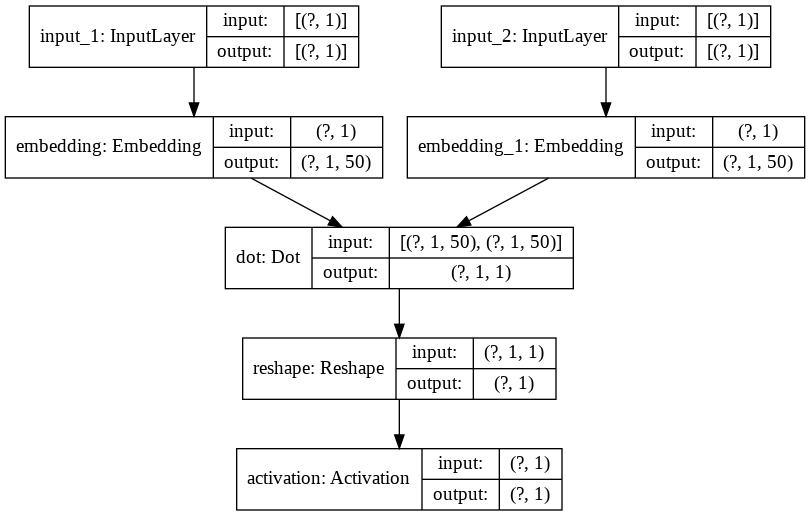

In [ ]:
model = word2vec()
model.summary()
plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
for epoch in range(1, 11):
  loss = 0
  for _, elem in enumerate(skip_grams):
    first_elem = np.array(list(zip(*elem[0]))[0], dtype='int32')
    second_elem = np.array(list(zip(*elem[0]))[1], dtype='int32')
    labels = np.array(elem[1], dtype='int32')
    X = [first_elem, second_elem]
    Y = labels
    loss += model.train_on_batch(X, Y)

  print('Epoch:', epoch, 'Loss:', loss)

Epoch: 1 Loss: 908.7029622197151
Epoch: 2 Loss: 822.7758551985025
Epoch: 3 Loss: 781.046897046268
Epoch: 4 Loss: 755.7153167948127
Epoch: 5 Loss: 735.4389285072684
Epoch: 6 Loss: 714.5166520997882
Epoch: 7 Loss: 689.7383028939366
Epoch: 8 Loss: 660.0654565356672
Epoch: 9 Loss: 625.4111469034106
Epoch: 10 Loss: 587.41333131399


In [ ]:
import gensim

f = open('skipgram.txt', 'w')
f.write('{} {}\n'.format(vocab_size-1, embed_size))
vectors = model.get_weights()[0]
for word, i in tokenizer.word_index.items():
  f.write('{} {}\n'.format(word, ' '.join(map(str, list(vectors[i, :])))))
f.close()

skipgram = gensim.models.KeyedVectors.load_word2vec_format('skipgram.txt', binary=False)

In [ ]:
skipgram.most_similar(positive=['soldier'])

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('traps', 0.8974606990814209),
 ('ammunitions', 0.8590653538703918),
 ('retalliates', 0.8530126810073853),
 ('patrols', 0.8395387530326843),
 ('booby', 0.793689489364624),
 ('indiscriminately', 0.7659371495246887),
 ('pilots', 0.7497424483299255),
 ('sneak', 0.7456728219985962),
 ('israeli', 0.7137306928634644),
 ('legitimize', 0.703777015209198)]

In [ ]:
skipgram.most_similar(positive=['world'])

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('ruff', 0.6390813589096069),
 ('suzy', 0.6372347474098206),
 ('ermianlary', 0.6293324828147888),
 ('colonies', 0.6252544522285461),
 ('mother', 0.6191424131393433),
 ('terror', 0.6178315877914429),
 ('robe', 0.6062974333763123),
 ('insecure', 0.5996068716049194),
 ('betrothed', 0.5990766882896423),
 ('fame', 0.598358690738678)]

### CBOW


#### CBOW 전처리

In [ ]:
def skipgram2cbow(skipgrams):
  cbows = []
  flag = 0
  for n in skip_grams:
    temp1 = []
    for t in n:
      if flag == 1:
        flag = 0
        temp1.append(t)
      else:
        flag = 1
        temp2 = []
        for x in t:
          temp2.append([x[1], x[0]])
        temp1.append(temp2)
    cbows.append(temp1)
  
  return cbows

In [ ]:
cbows = skipgram2cbow(skip_grams)

In [ ]:
pairs, labels = cbows[0][0], cbows[0][1]
for i in range(5):
  print("{:s}({:d}), {:s}({:d}) -> {:d}".format(
      idx2word[pairs[i][0]], pairs[i][0],
      idx2word[pairs[i][1]], pairs[i][1],
      labels[i]))

reports(982), blessing(12418) -> 1
unfortunate(5677), makes(201) -> 1
clearly(564), subsidizing(8691) -> 1
think(6), report(611) -> 1
ruin(12415), reputation(5676) -> 1


In [ ]:
print(len(cbows))
print(len(pairs))
print(len(labels))

2000
2220
2220


#### CBOW 모델 구성

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 1, 50)        1485300     input_3[0][0]                    
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 1, 50)        1485300     input_4[0][0]                    
_______________________________________________________________________________________

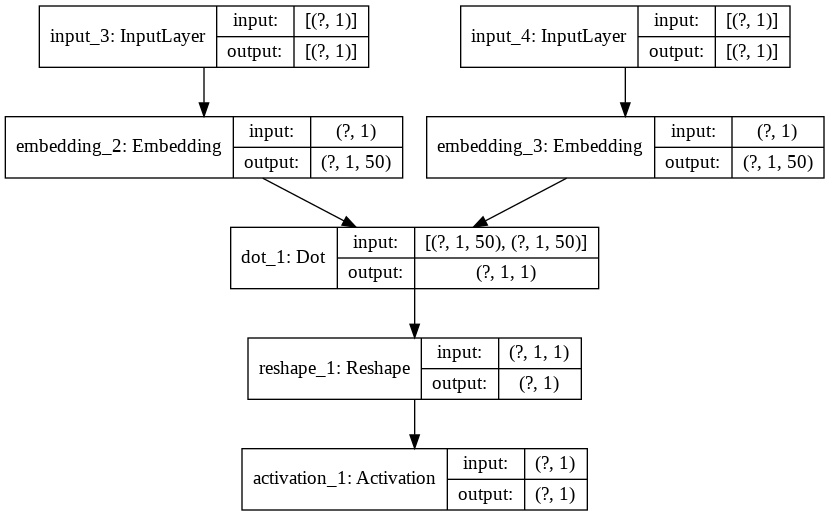

In [ ]:
model = word2vec()
model.summary()
plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
for epoch in range(1, 11):
  loss = 0
  for _, elem in enumerate(cbows):
    first_elem = np.array(list(zip(*elem[0]))[0], dtype='int32')
    second_elem = np.array(list(zip(*elem[0]))[1], dtype='int32')
    labels = np.array(elem[1], dtype='int32')
    X = [first_elem, second_elem]
    Y = labels
    loss += model.train_on_batch(X, Y)

  print('Epoch:', epoch, 'Loss:', loss)

Epoch: 1 Loss: 1181.3133001178503
Epoch: 2 Loss: 911.7061531245708
Epoch: 3 Loss: 822.5737919658422
Epoch: 4 Loss: 777.1473232656717
Epoch: 5 Loss: 748.1009210124612
Epoch: 6 Loss: 724.3466542288661
Epoch: 7 Loss: 700.5955307483673
Epoch: 8 Loss: 673.9933568909764
Epoch: 9 Loss: 643.5971593372524
Epoch: 10 Loss: 609.1827149223536


In [ ]:
import gensim

f = open('cbow.txt', 'w')
f.write('{} {}\n'.format(vocab_size-1, embed_size))
vectors = model.get_weights()[0]
for word, i in tokenizer.word_index.items():
  f.write('{} {}\n'.format(word, ' '.join(map(str, list(vectors[i, :])))))
f.close()

cbow = gensim.models.KeyedVectors.load_word2vec_format('cbow.txt', binary=False)

In [ ]:
cbow.most_similar(positive=['soldier'])

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('pilots', 0.9394441246986389),
 ('traps', 0.9387328028678894),
 ('commitments', 0.9384233951568604),
 ('vfrf', 0.9356690049171448),
 ('blaim', 0.9335338473320007),
 ('culminated', 0.9329688549041748),
 ('imprisonment', 0.9326211810112),
 ('harms', 0.9310446977615356),
 ('ephesians', 0.9295893311500549),
 ('bugunlerde', 0.9291462302207947)]

In [ ]:
cbow.most_similar(positive=['world'])

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('division', 0.9231580495834351),
 ('would', 0.915330171585083),
 ('every', 0.9140222072601318),
 ('likely', 0.9136790633201599),
 ('less', 0.9128392934799194),
 ('another', 0.9110150337219238),
 ('ones', 0.9109590649604797),
 ('tell', 0.9106425046920776),
 ('probably', 0.9099518060684204),
 ('michael', 0.9098786115646362)]